In [1]:
import cf_xarray as cfxr
import xarray as xr
import matplotlib.pyplot as plt

In [11]:
fp = "/home/ec2-user/tmp/fc2025030112__dmi_sf/dini/heightAboveGround.json"
ds = xr.open_zarr(f"reference::{fp}")
ds

<xarray.Dataset> Size: 44GB
Dimensions:  (time: 21, y: 1606, x: 1906, level: 9)
Coordinates:
    lat      (y, x) float64 24MB dask.array<chunksize=(1606, 1906), meta=np.ndarray>
  * level    (level) int64 72B 0 2 50 100 150 250 300 350 450
    lon      (y, x) float64 24MB dask.array<chunksize=(1606, 1906), meta=np.ndarray>
  * time     (time) datetime64[ns] 168B 2025-03-01T12:00:00 ... 2025-03-02T08...
  * x        (x) float64 15kB -1.528e+06 -1.526e+06 ... 2.28e+06 2.282e+06
  * y        (y) float64 13kB -1.589e+06 -1.587e+06 ... 1.619e+06 1.621e+06
Data variables: (12/37)
    100u     (time, y, x) float64 514MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    100v     (time, y, x) float64 514MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    10efg    (time, y, x) float64 514MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    10fg     (time, y, x) float64 514MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    10nfg    (time, y, x) float64 514MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    10si     (time, y, x) float64 514MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    ...       ...
    u        (time, level, y, x) float64 5GB dask.array<chunksize=(1, 1, 1606, 1906), meta=np.ndarray>
    ulwrf    (time, y, x) float64 514MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    unknown  (time, y, x) float64 514MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    v        (time, level, y, x) float64 5GB dask.array<chunksize=(1, 1, 1606, 1906), meta=np.ndarray>
    vis      (time, y, x) float64 514MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    z        (time, y, x) float64 514MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ekmi
    centreDescription:  Copenhagen
    subCentre:          255
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.Ha...

In [ ]:
# copy over cf standard-names where eccodes provides them

for var_name in ds.data_vars:
    if "cfName" in ds[var_name].attrs:
        ds[var_name].attrs["standard_name"] = ds[var_name].attrs["cfName"]
        
# u-wind component in general has paramter-id 131, but at 10m altitude is
# parameter 165 and at 100m altitude is parameter 228246:
#    shortName   paramId     level
#    10u         165         10
#    u           131         50
#    100u        228246      100
#    u           131         150
#    u           131         250
#    u           131         350
#    u           131         450
# same for v-wind component (in general paramId 132, 166 @ 10m, 228247 @ 100m):
#    shortName   paramId     level
#    10v         166         10
#    v           132         50
#    100v        228247      100
#    v           132         150
#    v           132         250
#    v           132         350
#    v           132         450

# this means that `u` and `v` actually have nan values at 10m and 100m
# altitudes, which we should replace with the values from `10u` and `10v`
# and `100u` and `100v` respectively

def merge_level_specific_params(ds, true_param, level, short_name):
    # select all levels that are not in the list, these are the ones that won't have nan values
    keep_levels = [l for l in ds[true_param].level.values if l != level]
    da_subset = ds[true_param].sel(level=keep_levels)

    da_special = ds[short_name]
    da_special["level"] = level
        
    da = xr.concat([da_subset, da_special], dim="level")
    return da

ds_copy = ds.copy()

special_params = {
    "10u": dict(true_param="u", level=10),
    "100u": dict(true_param="u", level=100),
    "10v": dict(true_param="v", level=10),
    "100v": dict(true_param="v", level=100),
    "2t": dict(true_param="t", level=2),
    "2r": dict(true_param="r", level=2),
}

for short_name, param_info in special_params.items():
    true_param = param_info["true_param"]
    ds_copy[true_param] = merge_level_specific_params(ds=ds, short_name=short_name, **param_info)
    ds_copy = ds_copy.drop_vars(short_name)

In [23]:
ds_copy.cf

Coordinates:
             CF Axes:   X, Y, Z, T: n/a

      CF Coordinates:   longitude: ['lon']
                        latitude: ['lat']
                        vertical, time: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   latitude: ['lat']
                        longitude: ['lon']

              Bounds:   n/a

       Grid Mappings:   n/a

Data Variables:
       Cell Measures:   area, volume: n/a

      Standard Names:   air_temperature: ['mn2t', 'mx2t', 't']
                        eastward_wind: ['u']
                        geopotential: ['z']
                        northward_wind: ['v']
                        relative_humidity: ['r']
                        specific_humidity: ['2sh']

              Bounds:   n/a

       Grid Mappings:   n/a

In [25]:
ds_copy.cf[["air_temperature"]]

<xarray.Dataset> Size: 6GB
Dimensions:  (time: 21, y: 1606, x: 1906, level: 9)
Coordinates:
    lon      (y, x) float64 24MB dask.array<chunksize=(1606, 1906), meta=np.ndarray>
    lat      (y, x) float64 24MB dask.array<chunksize=(1606, 1906), meta=np.ndarray>
  * level    (level) int64 72B 0 2 50 100 150 250 300 350 450
  * time     (time) datetime64[ns] 168B 2025-03-01T12:00:00 ... 2025-03-02T08...
  * x        (x) float64 15kB -1.528e+06 -1.526e+06 ... 2.28e+06 2.282e+06
  * y        (y) float64 13kB -1.589e+06 -1.587e+06 ... 1.619e+06 1.621e+06
Data variables:
    mn2t     (time, y, x) float64 514MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    mx2t     (time, y, x) float64 514MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    t        (time, level, y, x) float64 5GB dask.array<chunksize=(1, 1, 1606, 1906), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ekmi
    centreDescription:  Copenhagen
    subCentre:          255
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.Ha...

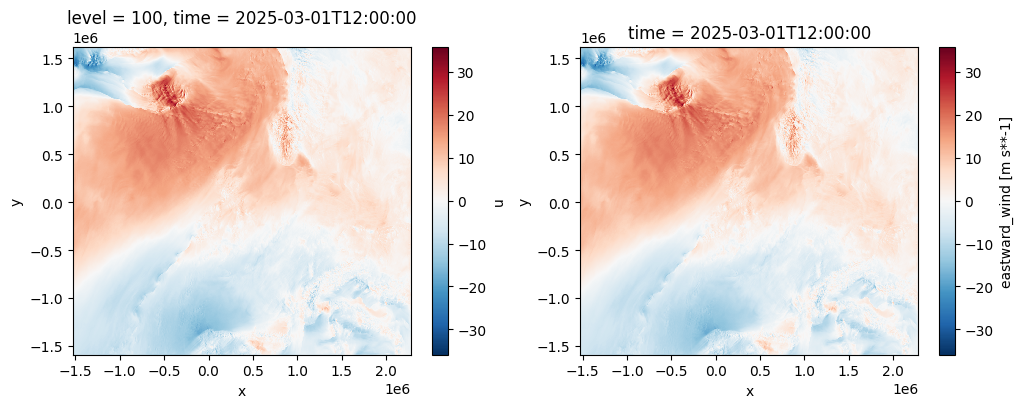

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

t0 = ds.isel(time=0).time
ds.u.sel(level=100, time=t0).plot(ax=axes[0])
ds["100u"].sel(time=t0).plot(ax=axes[1])

In [12]:
ds[["u", "100u"]]

<xarray.Dataset> Size: 5GB
Dimensions:  (time: 21, level: 9, y: 1606, x: 1906)
Coordinates:
    lat      (y, x) float64 24MB dask.array<chunksize=(1606, 1906), meta=np.ndarray>
  * level    (level) int64 72B 0 2 50 100 150 250 300 350 450
    lon      (y, x) float64 24MB dask.array<chunksize=(1606, 1906), meta=np.ndarray>
  * time     (time) datetime64[ns] 168B 2025-03-01T12:00:00 ... 2025-03-02T08...
  * x        (x) float64 15kB -1.528e+06 -1.526e+06 ... 2.28e+06 2.282e+06
  * y        (y) float64 13kB -1.589e+06 -1.587e+06 ... 1.619e+06 1.621e+06
Data variables:
    u        (time, level, y, x) float64 5GB dask.array<chunksize=(1, 1, 1606, 1906), meta=np.ndarray>
    100u     (time, y, x) float64 514MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ekmi
    centreDescription:  Copenhagen
    subCentre:          255
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.Ha...

In [13]:
ds[["2t", "t"]]

<xarray.Dataset> Size: 5GB
Dimensions:  (time: 21, y: 1606, x: 1906, level: 9)
Coordinates:
    lat      (y, x) float64 24MB dask.array<chunksize=(1606, 1906), meta=np.ndarray>
  * level    (level) int64 72B 0 2 50 100 150 250 300 350 450
    lon      (y, x) float64 24MB dask.array<chunksize=(1606, 1906), meta=np.ndarray>
  * time     (time) datetime64[ns] 168B 2025-03-01T12:00:00 ... 2025-03-02T08...
  * x        (x) float64 15kB -1.528e+06 -1.526e+06 ... 2.28e+06 2.282e+06
  * y        (y) float64 13kB -1.589e+06 -1.587e+06 ... 1.619e+06 1.621e+06
Data variables:
    2t       (time, y, x) float64 514MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    t        (time, level, y, x) float64 5GB dask.array<chunksize=(1, 1, 1606, 1906), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ekmi
    centreDescription:  Copenhagen
    subCentre:          255
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.Ha...

In [ ]:
ds.